In [101]:
import os

files = list(map(lambda x: "messages/" + x, os.listdir('messages')))
assert len(files) == len(set(files))

print(f"{len(files) = }")

len(files) = 1090


In [102]:
def getlines(_file):
    with open(_file) as read:
        return read.readlines()

Проверка всех файлов на единый стандарт:
"""
Subject: [0-9|space]+

[0-9|space]+

"""

In [103]:
def test_file(_file: str):
    lines = getlines(_file)
    assert len(lines) == 3
    line0, line1, line2 = lines

    assert len(line1.split()) == 0

    def check_words(_words):
        for word in _words:
            for letter in word:
                assert '0' <= letter <= '9'

    words = line0.split()
    assert words[0] == "Subject:"
    check_words(words[1:])
    check_words(line2.split())

for file in files:
    test_file(file)

In [104]:
def get_header(_file):
    return list(map(int, getlines(_file)[0].split()[1:]))

def get_message(_file):
    return list(map(int, getlines(_file)[2].split()))

In [105]:
all_words = set()
for file in files:
    all_words.update(get_header(file))
    all_words.update(get_message(file))
print(f"{min(all_words) = }")
print(f"{max(all_words) = }")

min(all_words) = 0
max(all_words) = 24747


In [106]:
def _get_types_messages(_files):
    return [1 if "legit" in _file else 0 for _file in _files]

def get_train_and_test(_files: list, div=0.8, shuffle=False):
    assert 0 < div < 1
    if shuffle:
        import random
        random.shuffle(_files)
    _train_files = _files[:int(len(_files) * div)]
    _test_files = _files[int(len(_files) * div):]
    _y_train = _get_types_messages(_train_files)
    _y_test = _get_types_messages(_test_files)
    return _train_files, _test_files, _y_train, _y_test

In [107]:
from itertools import count
max_word = max(all_words) + 1
_zeros = [0 for _ in range(max_word)]
_zeros2 = [0 for _ in range(2 * max_word)]

from scipy.sparse import csr_matrix
def to_csr(ma):
    return csr_matrix(ma)

# Способ векторизации: сколько встретилось
def get_matrix_ver0(_files): # Учитывать header и message одинаково
    ma = [_zeros.copy() for _ in range(len(_files))]

    for file_count, _file in zip(count(0), _files):
        for word_int in get_header(_file) + get_message(_file):
            ma[file_count][word_int] += 1

    return to_csr(ma)

# Способ векторизации: сколько встретилось
def get_matrix_ver1(_files): # Учитывать header и message раздельно
    ma = [_zeros2.copy() for _ in range(len(_files))]

    for file_count, _file in zip(count(0), _files):
        for word_int in get_header(_file):
            ma[file_count][word_int] += 1
        for word_int in get_message(_file):
            ma[file_count][word_int + max_word] += 1

    return to_csr(ma)

# Способ векторизации: встретилось или нет
def get_matrix_ver2(_files): # Учитывать header и message одинаково
    ma = [_zeros.copy() for _ in range(len(_files))]

    for file_count, _file in zip(count(0), _files):
        for word_int in get_header(_file) + get_message(_file):
            ma[file_count][word_int] = 1 # += -> =

    return to_csr(ma)

# Способ векторизации: встретилось или нет
def get_matrix_ver3(_files): # Учитывать header и message раздельно
    ma = [_zeros2.copy() for _ in range(len(_files))]

    for file_count, _file in zip(count(0), _files):
        for word_int in get_header(_file):
            ma[file_count][word_int] = 1 # += -> =
        for word_int in get_message(_file):
            ma[file_count][word_int + max_word] = 1 # += -> =

    return to_csr(ma)

In [108]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

model = MultinomialNB()

versions = {
    get_matrix_ver0: "Одинаково, сколько встретилось",
    get_matrix_ver1: "Раздельно, сколько встретилось",
    get_matrix_ver2: "Одинаково, встретилось или нет",
    get_matrix_ver3: "Раздельно, встретилось или нет",
}

def once(*args, **kwargs):
    train_files, test_files, y_train, y_test = get_train_and_test(*args, **kwargs)
    for func, description in versions.items():
        train = func(train_files)
        test = func(test_files)

        model.fit(train, y_train)
        pred = model.predict(test)

        print("Ошибок: {} из {}".format(sum(map(lambda x: 0 if x[0]==x[1] else 1, zip(y_test, pred))), len(y_test)))

        scores = list(map(lambda x: x[1], model.predict_proba(test)))
        print("AUC:", metrics.roc_auc_score(y_test, scores))

        fpr, tpr, _ = metrics.roc_curve(y_test, scores)
        plt.plot(fpr,tpr)
        plt.title(description)
        plt.show()
        print()

def mean(repeat=5, *args, **kwargs):
    for func, description in versions.items():
        mean_ma = [0, 0, 0]

        print(description+":")
        for i in range(repeat):
            train_files, test_files, y_train, y_test = get_train_and_test(*args, **kwargs, shuffle=True)
            train = func(train_files)
            test = func(test_files)

            model.fit(train, y_train)
            pred = model.predict(test)
            scores = list(map(lambda x: x[1], model.predict_proba(test)))

            mist = sum(map(lambda x: 0 if x[0]==x[1] else 1, zip(y_test, pred)))
            auc = metrics.roc_auc_score(y_test, scores)
            mean_ma[0] += mist
            mean_ma[1] += len(y_test)
            mean_ma[2] += auc

            print("Ошибок: {} из {}; AUC: {}".format(
                mist,
                len(y_test),
                auc,
            ))
        print("В общем ошибок: {} из {}\nСредний AUC: {}".format(
            mean_ma[0],
            mean_ma[1],
            mean_ma[2] / repeat,
        ))
        print()

In [109]:
mean(_files=files)

Одинаково, сколько встретилось:
Ошибок: 15 из 218; AUC: 0.9751214109227231
Ошибок: 12 из 218; AUC: 0.9844912102772143
Ошибок: 7 из 218; AUC: 0.986067977915804
Ошибок: 11 из 218; AUC: 0.9770810258157961
Ошибок: 9 из 218; AUC: 0.9953991650336542
В общем ошибок: 54 из 1090
Средний AUC: 0.9836321579930385

Раздельно, сколько встретилось:
Ошибок: 11 из 218; AUC: 0.9831598544469832
Ошибок: 9 из 218; AUC: 0.9893892339544514
Ошибок: 9 из 218; AUC: 0.9869595058339053
Ошибок: 15 из 218; AUC: 0.9795979986197377
Ошибок: 9 из 218; AUC: 0.9800101214574899
В общем ошибок: 53 из 1090
Средний AUC: 0.9838233428625134

Одинаково, встретилось или нет:
Ошибок: 6 из 218; AUC: 0.9983872336813514
Ошибок: 8 из 218; AUC: 0.9973029919932576
Ошибок: 2 из 218; AUC: 0.9963109128345916
Ошибок: 5 из 218; AUC: 0.9999134723544173
Ошибок: 7 из 218; AUC: 0.998472116119175
В общем ошибок: 28 из 1090
Средний AUC: 0.9980773453965586

Раздельно, встретилось или нет:
Ошибок: 6 из 218; AUC: 0.9955084745762712
Ошибок: 8 из 218;

Ошибок: 12 из 218
AUC: 0.9811731557377049


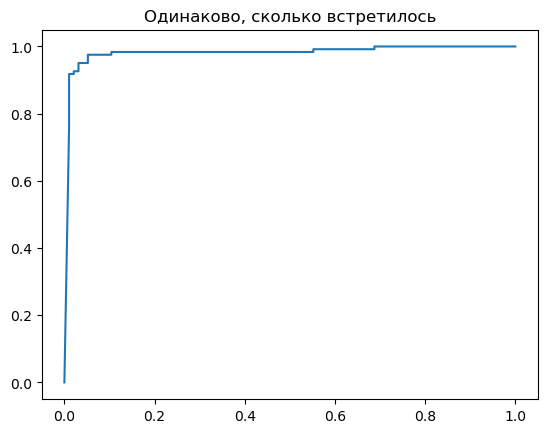


Ошибок: 14 из 218
AUC: 0.9809170081967213


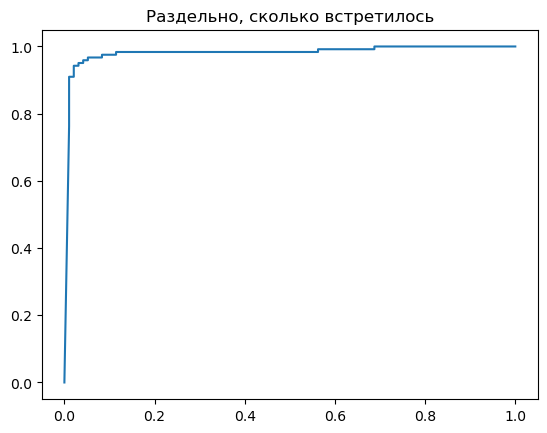


Ошибок: 4 из 218
AUC: 0.9994877049180327


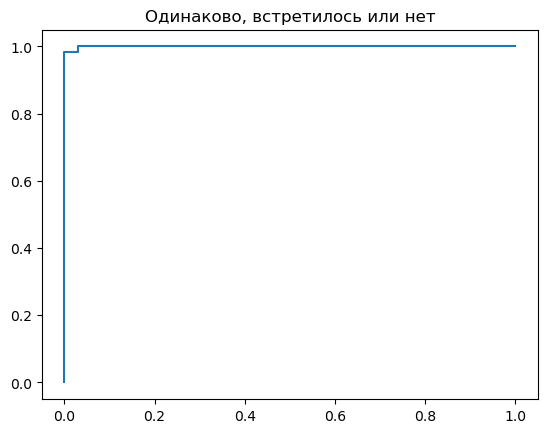


Ошибок: 4 из 218
AUC: 0.9997438524590163


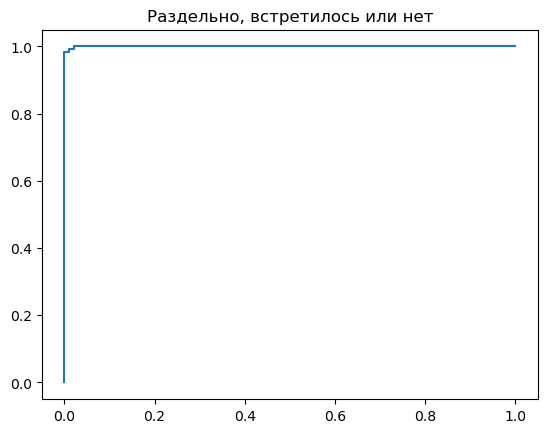

In [110]:
once(files, 0.8, True)

### 6 пункт: Измените априорное распределение для выбранной модели таким образом, чтобы число хороших сообщений классифицированных как спам равнялось нулю. При этом точность должна быть максимально возможной.

Априорное распределение влияет в основном при принятии решения в спорных моментах.

Чтобы гарантировать, что предсказание для любых наборов данных будет удовлетворять условию, необходимо и достаточно предсказывать, что все сообщения будут хорошими:
model = MultinomialNB(class_prior=[->0, ->+inf])
Таким образом для любых наборов данных будет гарантировано, что число хороших сообщений классифицированных как спам равняется нулю.

Если необходимо найти априорное распределение для заранее определенных наборов данных, то можно просто найти такой аргумент b, чтобы условие выполнялось:
model = MultinomialNB(class_prior=[1/b, b])
Для максимизации можно использовать бинпоиск (Оставим для будущих поколений)



In [124]:
train_files, test_files, y_train, y_test = get_train_and_test(files, shuffle=True)
train = get_matrix_ver2(train_files)
test = get_matrix_ver2(test_files)

if True:
    model = MultinomialNB(class_prior=[1e-64, 1e64])
    model.fit(train, y_train)
    pred = model.predict(test)
    mist = sum(map(lambda x: 1 if x[0]==1 and x[1]==0 else 0, zip(y_test, pred)))
    print(f"{mist = }")

if True:
    b = 1
    while True:
        model = MultinomialNB(class_prior=[1/b, b])
        model.fit(train, y_train)
        pred = model.predict(test)
        mist = sum(map(lambda x: 1 if x[0]==1 and x[1]==0 else 0, zip(y_test, pred)))
        if mist == 0:
            break
        b *= 10
print(f"{b = }")

mist = 0
b = 1000000000000


In [129]:
train_files, test_files, y_train, y_test = get_train_and_test(files, shuffle=True)
train = get_matrix_ver2(train_files)
test = get_matrix_ver2(test_files)

rng = range(-64, 64)
y = list()

for i in rng:
    b = 2 ** i
    model = MultinomialNB(class_prior=[1, b])
    model.fit(train, y_train)
    pred = model.predict(test)

    mist = sum(map(lambda x: 0 if x[0]==x[1] else 1, zip(y_test, pred)))

    ## scores = list(map(lambda x: x[1], model.predict_proba(test)))
    ## auc = metrics.roc_auc_score(y_test, scores)

    # mist = 0
    # for left, right in zip(y_test, pred):
    #     if left != right:
    #         mist += 1

    y.append((len(pred) - mist) / len(pred))
    ## y.append(auc)


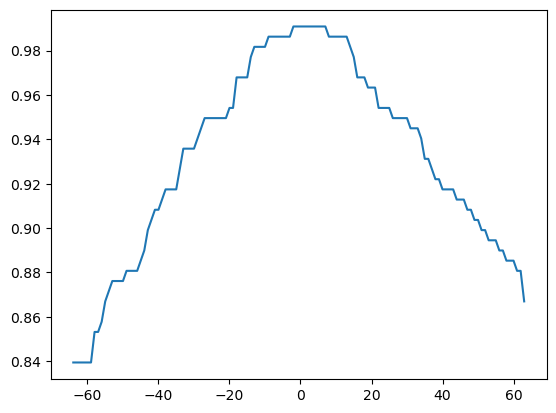

In [130]:
plt.plot(rng, y)
plt.show()